# RL homework 1
**Due date: 19 February 2017, 11:55am (lunch time, not mid-night!)**

# Nick Thomson 16121669 Ucaknth 

## How to submit

When you have completed the exercises and everything has finsihed running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **<student_id>_ucldm_hw1.ipynb** before the deadline above.

Also send a sharable link to the notebook at the following email: xxx@mail.com

## Context

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

## Background reading

* Sutton and Barto (2018), Chapters 1 and 2

# The Assignment

### Objectives

You will use Python and TensorFlow to implement several bandit algorithms.

You will then run these algorithms on a multi-armed Bernoulli bandit problem, to understand the issue of balancing exploration and exploitation.

# Setup

### Import Useful Libraries

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

### Set options

In [0]:
np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

### A generic multi-armed bandit class, with Bernoulli rewards

In [0]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""
  
  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or tf.int32 that specifies which arm to pull.

    Returns:
      A sampled reward according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

### Helper functions

In [0]:
def smooth(array, smoothing_horizon=100., initial_value=0.):
  """smoothing function for plotting"""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def one_hot(array, depth):
  """Multi-dimensional one-hot"""
  a = np.array(array)
  x = a.flatten()
  b = np.eye(depth)[x, :depth]
  return b.reshape(a.shape + (depth,))

def plot(algs, plot_data, optimal_value, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 3
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(15, 5*n_rows))
  
  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)
      ax.set_facecolor('white')

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg in current_algs:
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.6, label=alg.name)[0]
        else:
          line = plt.plot(m, alpha=0.6, label=alg.name)[0]
          plt.fill_between(range(number_of_steps), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if not p.log_plot:
        plt.plot([0, number_of_steps], [optimal_value]*2, '--k', label='optimal')

      plt.ylim(p.ylim)
      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit, algs, repetitions):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  action_dict = {}

  for alg in algs:
    reward_dict[alg.name] = []
    action_dict[alg.name] = []

    for _ in range(repetitions):
      alg.reset()
      reward_dict[alg.name].append([])
      action_dict[alg.name].append([])
      action = None
      reward = None
      for i in range(number_of_steps):
        try:
          action = alg.step(action, reward)
        except:
          print(alg, action, reward)
        reward = bandit.step(action)
        reward_dict[alg.name][-1].append(reward)
        action_dict[alg.name][-1].append(action)
        
  return reward_dict, action_dict

def train_agents(agents, number_of_arms, number_of_steps, repetitions=30,
                 success_reward=1., fail_reward=0.):

  success_probabilities = np.arange(0.25, 0.75 + 1e-6, 0.5/(number_of_arms - 1))
  bandit = BernoulliBandit(success_probabilities, success_reward, fail_reward)

  max_p = np.max(success_probabilities)
  min_p = np.min(success_probabilities)
  ylim_max = max_p*success_reward + (1 - max_p)*fail_reward
  ylim_min = min_p*success_reward + (1 - min_p)*fail_reward
  dif = ylim_max - ylim_min
  ylim = (ylim_min - 0.1*dif, ylim_max + 0.1*dif)

  max_prob = np.max(success_probabilities)
  optimal_value = max_prob*success_reward + (1 - max_prob)*fail_reward

  reward_dict, action_dict = run_experiment(bandit, agents, repetitions)
  
  smoothed_rewards = {}
  expected_rewards = {}
  regrets = {}
  for agent, rewards in reward_dict.items():
    smoothed_rewards[agent] = np.array(rewards)
  for agent, actions in action_dict.items():
    p_success = one_hot(actions, number_of_arms).dot(success_probabilities)
    expected_rewards[agent] = p_success*success_reward + (1 - p_success)*fail_reward
    regrets[agent] = optimal_value - expected_rewards[agent]

  PlotData = namedtuple('PlotData', ['title', 'data', 'log_plot', 'ylim'])
  plot_data = [
      PlotData(title='Smoohted rewards', data=smoothed_rewards,
               log_plot=False, ylim=ylim),
      PlotData(title='Expected rewards', data=expected_rewards,
               log_plot=False, ylim=ylim),
      PlotData(title='Current Regret', data=regrets,
               log_plot=True, ylim=(1e-2, 1)),
      PlotData(title='Total Regret',
               data=dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()]),
               log_plot=False, ylim=(1e-0, 5e2)),
  ]
  plot(agents, plot_data, optimal_value)

### Random agent

In [0]:
class Random(object):
  """A random agent.
  
  This agent returns an action between 0 and 'number_of_arms', 
  uniformly at random. The 'previous_action' argument of 'step'
  is ignored.
  """

  def __init__(self, number_of_arms):
    self._number_of_arms = number_of_arms
    self.name = 'random'
    self.reset()

  def step(self, previous_action, reward):
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass

# A1: Implement agents

Each agent, should implement the following methods:

### `step(self, previous_action, reward)`:
should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

### `reset(self)`:
resets statistics (should be equivalent to constructing a new agent from scratch).  Make sure that the initial values (after a reset) are all zero.

### `__init__(self)`:
The `__init__` can be *the same* as for the random agent above (with the exception of $\epsilon$-greedy---see below), except for the name, which should be unique (e.g., 'greedy', 'ucb', etc.)

All agents should be in pure Python - so you cannot use TensorFlow to, e.g., compute gradients.  Using `numpy` is fine.



## Agent 1: greedy
**[10 pts]** You should **implement the greedy** agent, that

1.   Estimates the average reward for each action that was selected so far, and
2.   Always selects the highest-valued action.


In [0]:
class Greedy(object):

  def __init__(self, number_of_arms):
    self._number_of_arms = number_of_arms
    self.values = [0.0] * self._number_of_arms
    self.pulls = [0.0] * self._number_of_arms
    self.Q = [0.0] * self._number_of_arms
    self.name = 'greedy'
    self.reset()
  
  def step(self, previous_action, reward):
    if previous_action == None:
        
        return np.random.randint(self._number_of_arms)

    self.values[previous_action] += reward
    self.pulls[previous_action] += 1.0    
    self.Q[previous_action] = (self.values[previous_action]/self.pulls[previous_action])
    return np.argmax(self.Q)


  def reset(self):
    pass


In [0]:

def softmax(output_array):
    logits_exp = np.exp(output_array)
    return logits_exp / np.sum(logits_exp, axis=0, keepdims = True)



## Agent 2: $\epsilon$-greedy
**[15 pts]** You should **implement an $\epsilon$-greedy** agent, that selects the highest-valued action with probability $1 - \epsilon$, and otherwise selects an action at random.

The exploration parameter $\epsilon$ should be given in the `__init__`, as indicated in the code below.


In [0]:
class EpsilonGreedy(object):

  def __init__(self, number_of_arms, epsilon=0.1):
    self._number_of_arms = number_of_arms
    self._epsilon = epsilon
    self.values = [0.0] * self._number_of_arms
    self.pulls = [0.0] * self._number_of_arms
    self.Q = [0.0] * self._number_of_arms
    self.name = 'epsilon-greedy epsilon:{}'.format(epsilon)
    self.reset()
  
  def step(self, previous_action, reward):
    if previous_action == None:
        return np.random.randint(self._number_of_arms)

    self.values[previous_action] += reward
    self.pulls[previous_action] += 1.0    
    if np.random.random() > self._epsilon:
        self.Q[previous_action] = self.Q[previous_action] + ((reward-self.Q[previous_action])/self._number_of_arms)
        return np.argmax(self.Q)

    else:
        return np.random.randint(self._number_of_arms)

  def reset(self):
    pass



## Agent 3: UCB
**[15 pt]** You should **implement** an agent that **explores with UCB**. 


In [0]:
class UCB(object):

  def __init__(self, number_of_arms):
    self._number_of_arms = number_of_arms
    self.values = [1.0] * self._number_of_arms
    self.pulls = [1.0] * self._number_of_arms
    self.Q = [0.0] * self._number_of_arms
    self.steps = 0
    self.name = 'ucb'
    self.reset()

  def step(self, previous_action, reward):
    self.steps +=1
    if previous_action == None:
        return np.random.randint(self._number_of_arms)
    self.values[previous_action] += reward
    self.pulls[previous_action] += 1.0    
    self.Q[previous_action] = self.Q[previous_action] + (reward-self.Q[previous_action])/self._number_of_arms
    a = self.Q + 1/2* (np.sqrt(np.divide(np.log(self.steps),self.pulls[previous_action])))
    return np.argmax(a)

  def reset(self):
    pass



## Agent 4: REINFORCE agents
You should implement agents that implement REINFORCE policy-gradient methods

The policy should be a softmax on action preferences:
$$\pi(a) = \frac{\exp(p(a))}{\sum_b \exp(p(b))}\,.$$

The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.



## Assignment 4a:
In the next text field, write down the update function to the preferences for all actions $\{a_1, \ldots, a_n\}$ if you selected a specific action $A_t = a_i$ and received a reward of $R_t$.

In other words, complete:
\begin{align*}
p_{t+1}(a)
& = \ldots
&& \text{for $a = A_t$} \\
p_{t+1}(b)
& = \ldots
&& \text{for all $b \ne A_t$}
\end{align*}

**[10 pts]** **Instructions**: please provide answer in markdown below.

We initialise the updates as a form of gradient ascent. 

$$ p_{t+1} (a) = p_t (a) + \alpha \frac{\partial \sum_x \pi_t (x) q_x(X)}{\partial p_t (a)} $$ 

We can then simplify the RHS in order to give, where $\bar{R_t}$ is the baseline used in the final updates

$$ =  \sum_x (q_x(x) - \bar{R_t}) \frac{\partial \pi_t (x)}{\partial p_t (a)} $$ 

Next we must multiply each term on the RHS by $ \pi_t(x)/\pi_t(x) $

$$ =  \sum_x \pi_t(x) (q_x(x) - \bar{R_t}) \frac{\partial \pi_t (x)}{\partial p_t (a)}/\pi_t (x) $$ 

The expectation of this can now be taken by marginalising over x

$$ E[(R_t - \bar{R_t}) \frac{\partial \pi_t (A_t)}{\partial p_t (a)}/\pi_t (A_t)] $$

In order to use this for updates we must simplify $\frac{\partial \pi_t (A_t)}{\partial p_t (a)}/\pi_t (A_t)$

We use the quotient rule to give

$$  = \frac{\frac{\partial e^{p_t (x)}}{\partial p_t (a)} \sum^k_{y=1} e^{p_t} (y) - e^{p_t (x)} \frac{\partial \sum^k_{y=1} e^{p_t} (y)}{\partial p_t (a)} } {(\sum^k_{y=1} e^{p_t} (y))^2} $$

$$  = \frac{1_{a=x} e^{p_t (x)}\sum^k_{y=1} e^{p_t} (y) - e^{p_t (x)}  e^{p_t (a)}} {(\sum^k_{y=1} e^{p_t} (y))^2} $$

$$ = \frac{1_{a=x} e^{p_t (x)}}{\sum^k_{y=1} e^{p_t} (y)} - \frac{e^{p_t (x)}  e^{p_t (a)}}{(\sum^k_{y=1} e^{p_t} (y))^2} $$

$$ = 1_{a=x} \pi_t (x) - \pi_t (x) \pi_t (a) $$

$$ = \pi_t (x) (1_{a=x} - \pi_t (a)) $$

Substituting this back into 

$$ p_{t+1} (A_t) = p_t (A_t) + \alpha (R_t - \bar{R_t}) ( 1_{a=x} - \pi_t (A_t))  $$ 

As $1_{a=x} = 0$ when $b \neq A_t$, the equation is seperated in to the following:

$$ p_{t+1} (a) = p_t (a) + \alpha (R_t - \bar{R_t}) ( 1 - \pi_t (a))  $$ 

$$ p_{t+1} (b) = p_t (b) - \alpha (R_t - \bar{R_t}) (\pi_t (b))  $$ 


## Assignment 4b:
**[15 + 5 pts]** You should **implement a vanilla REINFORCE agent with** and **without a baseline**.
Whether or not a baseline is used should be a boolean constructor argument.

In [0]:
class REINFORCE(object):
 
  def __init__(self, number_of_arms, step_size=0.1, baseline=False):
    self._number_of_arms = number_of_arms
    self._lr = step_size
    self.actions = 0
    self.rewards = 0
    self.H = np.zeros(self._number_of_arms)
    self.name = 'reinforce, baseline: {}'.format(baseline)
    self._baseline = baseline
    self.reset()
  
  def step(self, previous_action, reward):
    if previous_action == None:
        return np.random.randint(self._number_of_arms)
        
    a = previous_action
    self.actions += 1.0
    self.rewards += reward  
    
    if self._baseline == True:
        baseline = (reward - np.divide(self.rewards, self.actions))
    else: 
        baseline = (reward - 0.0)
        
    soft_H = softmax(self.H)
    self.H[a] = self.H[a] + (self._lr*(baseline)*(1 - soft_H[a]))
    mask = np.ones(self._number_of_arms,dtype=bool)
    mask[a] = 0
    self.H[mask] = self.H[mask] - self._lr*(baseline)*soft_H[mask]
    soft_H_pick = softmax(self.H)
    return np.random.choice(self._number_of_arms, 1, p=soft_H_pick)

  def reset(self):
    pass


# Assignment 5: Analyse Results

### Run the cell below to train the agents and generate the plots for the first experiment.

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

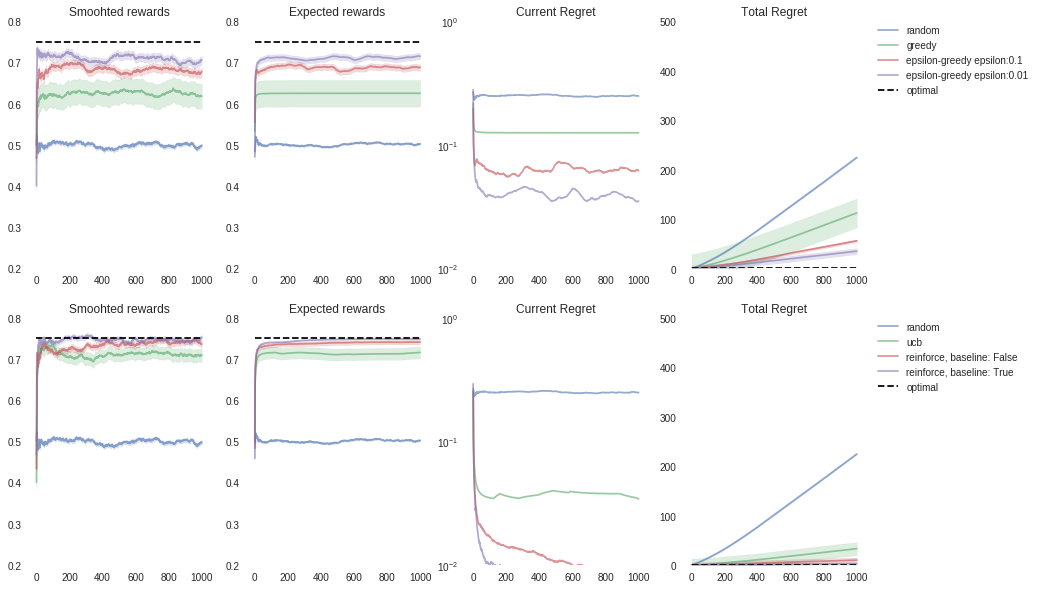

In [14]:
number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(number_of_arms),
    Greedy(number_of_arms),
    EpsilonGreedy(number_of_arms, 0.1),
    EpsilonGreedy(number_of_arms, 0.01),
    UCB(number_of_arms),
    REINFORCE(number_of_arms),
    REINFORCE(number_of_arms, baseline=True)
]

train_agents(agents, number_of_arms, number_of_steps)
plt.show()

## Assignment 5 a.
(Answer inline in the markdown below each question.)

**[5pts]** Name the best and worst algorithms, and explain (with one or two sentences each) why these are best and worst.

The best algorithm is Reinforce - This is due to the nature in which the H values update, they allow for exploration in a deterministic which is then converted to a probability distribution. This allows for more exploration early while later on this probability distribution will select the optimal action with greater probability. 

Greedy is the worst algorithm. This is due to the nature of the Q valus, if the early steps return no reward then they will not be picked again. This can mean that the optimal action maybe reduced to probability of selction = 0 and thus it won't be selected again. When run the experiments the greedy algorithm often had the lowest rewards and the highest variance.

**[5pts]** Which algorithms are guaranteed to have linear total regret?

$\epsilon$-greedy & Greedy. This is due to static nature of the problem. $\epsilon$-greedy can have a logarithmic regret with $\epsilon$ decay, however with a static $\epsilon$ and static probability of the rewards for each action the regret will become linear. 

**[5pts]** Which algorithms are guaranteed to have logarithmic total regret?

These have log regret due to the deterministic nature of exploration, it therefore tends to the optimal value much faster (with log time). This can be seen in the current regret graphs in the experiment 1.

**[5pts]** Which of the $\epsilon$-greedy algorithms performs best?  Which should perform best in the long run?

$\epsilon$ = 0.01 would perform better in the long run than 0.1. This is due to the reduction in the standard deviation of the reward of each action over time. When in the early steps, the exploration given by the $\epsilon$ is important in order to find the right action to exploit. However, as the actions are explored further, the standard deviation tends to 0 and the optimal action will be discovered. At this stage it would be optimal to select this action at every step, however the algorithm selects this action with probability 1-$\epsilon$, therefore as $\epsilon$ tends to 0, the optimal action is selected more. 


### Run the cell below to train the agents and generate the plots for the second experiment.

Trains the agents on a bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

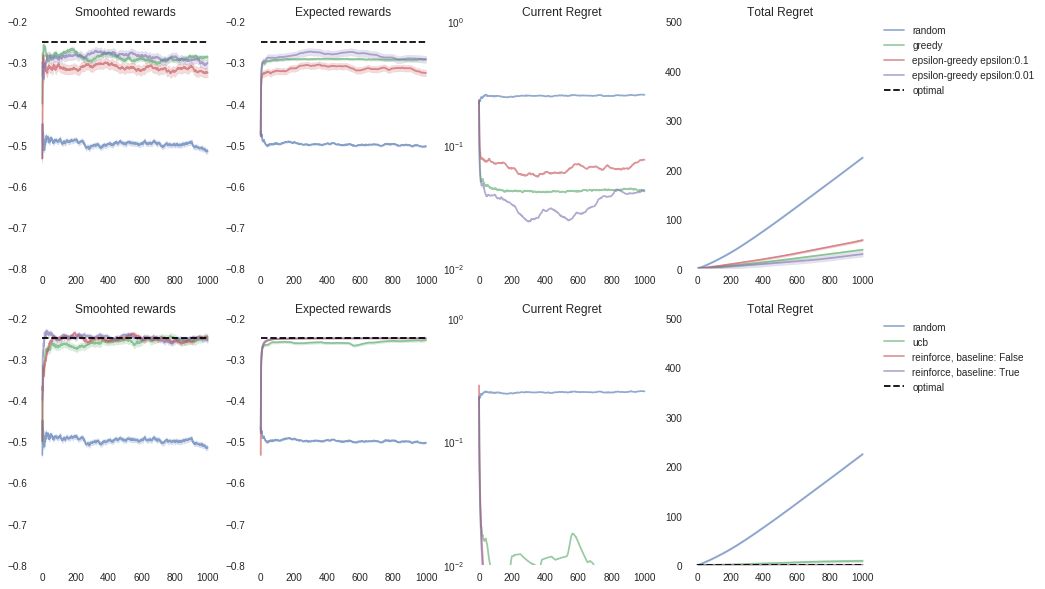

In [15]:
#@title Experiment 2: R = 0 on success, R = -1 on failure.
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)
plt.show()

## Assignment 5 b.
(Answer inline in the markdown.)

**[10pts]** Explain which algorithms improved from the changed rewards, and why.

(Use at most two sentences per algorithm and feel free to combine explanations for different algorithms where possible).

Greedy & $\epsilon$-greedy - Improved - As the initialisation Q is the same as the rewards values there is more exploration of the actions in the early stages. This is because argmax will either select an action where 100% of the steps have lead to a reward or explore a new action, this is equivalent to optimistic initial values for Q.

UCB - No Difference - The change in rewards made little difference to the outcome of the experiment. Any changes could be due to the in initial Q values effecting the way in which the algorithm explores in the early stages. 

Reinforce (No Baseline) - No Difference - The baseline is there to stop scaling of rewards effecting the selected action. As rewards limits still differ by 1, this does not change.

Reinforce (Baseline) - No Difference - The baseline means that this algorithm still performs similarly to No Baseline. Meaning it selected in much the same way as before. 